<img src="images/JHI_STRAP_Web.png" style="width: 150px; float: right;">
# 03 - Using `BLAST+` Programmatically with Biopython

## Table of Contents

1. [Introduction](#introduction)
2. [Python imports](#imports)
3. [Running and analysing a local BLASTX search](#blastx)
  1. [Run `BLASTX`](#runblastx)
  2. [Load `BLASTX` results](#loadresults)
  3. [Exercise 01](#ex01)

<a id="introduction"></a>
## Introduction

This notebook presents examples of methods for using `BLAST` programmatically, with a local installation of `BLAST`.

It can be very convenient to use a web BLAST in the browser - such as the [NCBI interface](https://blast.ncbi.nlm.nih.gov/Blast.cgi), or a project-specific instance (like this one at the [PGSC](http://solanaceae.plantbiology.msu.edu/blast.shtml)) - for `BLAST` searches, but there can be limitations to this approach.

It may not be practical to submit a large number of simultaneous queries via a web form, either because the interface prevents this, or because it is tiresome to point-and-click over and over again. It may be that the interface does not make it easy to change custom options that you might want to modify to help refine your query. It could be the case that the web database does not contain sequences that you are interested in searching against (if, for example, some of the sequences are proprietary), or it might not be constrained to a relevant set of organisms, so the search might take much longer than it needs to for your purposes. If you need to repeat a query, it can be awkward to get the same settings every time.

<br><div class="alert-success">
<b>Using a programmatic approach to submitting `BLAST` queries provides a number of potential advantages</b>
</div></br>

* It is easy to set up repeatable searches for many sequences, or collections of sequences
* It is easy to read in the search results and conduct downstream analyses that add value to your search
* The same code can be readily adapted to different BLAST instances, databases, and servers

The code that we develop in this notebook will be adapted for use in the next notebook: `02-programming_web_blast`, but we focus on a local installation now to understand the principles.

<a id="imports"></a>
## Python imports

To interact with the local installation of `BLAST`, we will use the free `Biopython` programming tools. These provide an interface to interact with `BLAST`, run jobs, and to read in the output files.

To collate the `BLAST` search results as dataframes/tables for analysis, we will use the `pandas` package.

To graph the downstream results, we will use the `seaborn` visualisation package.

We import these tools, and some standard library packages for working with files (`os`) below.

In [1]:
# Show plots as part of the notebook
%pylab inline

# Standard library packages
import os

# Import Pandas and Seaborn
import pandas as pd
import seaborn as sns

# Import Biopython tools for running local BLASTX
from Bio.Blast.Applications import NcbiblastxCommandline

Populating the interactive namespace from numpy and matplotlib


<a id="blastx"></a>
## Running and analysing a local BLASTX search

As a first worked example, we will run a local `BLASTX` search, querying a nucleotide sequence against a local protein database, to identify potential homologues.

* The database comprises predicted gene products from five *Kitasatospora* genomes
* The query is a single nucleotide sequence of a predicted penicillin-binding protein from *Kitasatospora* sp. CB01950

We will use Python/`biopython` in the code blocks below to first perform the `BLASTX` search, then parse the results into a `pandas` dataframe, and finally we will plot some summary statistics using `seaborn`.

<a id="runblastx"></a>
### Run `BLASTX`

There are two steps to running a `BLAST` command line with `biopython`.

1. Create the command-line object
2. Run the command-line object

To create the command-line, we need to provide the same information as if we were running `BLAST` at the terminal: the location of the query sequence file, the location of the database, and any arguments that modify the type of `BLAST` search we are running.

Firstly, we define two variables that contain the paths to the input data, and the location we want to place our `BLAST` output file. Then we define variables that contain paths to: the input query sequence file; the database we're searching against; and the file containing `BLAST` output

In [2]:
# Define paths to input and output directories
datadir = os.path.join('data', 'kitasatospora')   # input
outdir = os.path.join('output', 'kitasatospora')  # output
os.makedirs(outdir, exist_ok=True)                # create output directory if it doesn't exist

# Define paths to input and output files
query = os.path.join(datadir, 'k_sp_CB01950_penicillin.fasta')           # query sequence(s)
db = os.path.join(datadir, 'kitasatospora_proteins.faa')                 # BLAST database
blastout = os.path.join(outdir, 'AMK19_00175_blastx_kitasatospora.tab')  # BLAST output

<div class="alert-danger">
When using a Jupyter notebook, if you ever forget how exactly to use a Python function or class, you can use Python's inbuilt `help()` system. We use this in the cell below to get information on how to construct a `BLASTX` command, using the `NcbiblastxCommandline` object we imported above:
</div>

In [3]:
# Get help with how to construct the command-line
help(NcbiblastxCommandline)

Help on class NcbiblastxCommandline in module Bio.Blast.Applications:

class NcbiblastxCommandline(_NcbiblastMain2SeqCommandline)
 |  Wrapper for the NCBI BLAST+ program blastx (nucleotide query, protein database).
 |  
 |  With the release of BLAST+ (BLAST rewritten in C++ instead of C), the NCBI
 |  replaced the old blastall tool with separate tools for each of the searches.
 |  This wrapper therefore replaces BlastallCommandline with option -p blastx.
 |  
 |  >>> from Bio.Blast.Applications import NcbiblastxCommandline
 |  >>> cline = NcbiblastxCommandline(query="m_cold.fasta", db="nr", evalue=0.001)
 |  >>> cline
 |  NcbiblastxCommandline(cmd='blastx', query='m_cold.fasta', db='nr', evalue=0.001)
 |  >>> print(cline)
 |  blastx -query m_cold.fasta -db nr -evalue 0.001
 |  
 |  You would typically run the command line with cline() or via the Python
 |  subprocess module, as described in the Biopython tutorial.
 |  
 |  Method resolution order:
 |      NcbiblastxCommandline
 |      

The information above tells how to pass the paths to the query sequence, database, and how to specify other values to control `BLASTX`, e.g.:

```
cline = NcbiblastxCommandline(query="m_cold.fasta", db="nr", evalue=0.001)
```

<br><div class="alert-success">
We use this information to create a command-line object in the variable `cmd_blastx` that we can use to run our `BLASTX` query.
</div></br>

We provide the locations of the query sequence (the penicillin-binding protein), the database we're searching against (the proteins from five other *Kitosatospora* species), and a location to write the output. 

<br><div class="alert-warning">
We also specify the output format we require, with the option `outfmt=6`. This asks `BLASTX` to write a tab-separated tabular plain text file. This differs from the usual human-readable output you may be used to, but is particularly convenient for automated processing.
</div></br>

In [4]:
# Create command-line for BLASTX
cmd_blastx = NcbiblastxCommandline(query=query, out=blastout, outfmt=6, db=db)

The `cmd_blastx` object now contains instructions that are equivalent to running `BLASTX` at the command-line. We can even get it to print out a command-line that we could copy-and-paste into the terminal, to run the search:

In [5]:
# Get a working command-line
print(cmd_blastx)

blastx -out output/kitasatospora/AMK19_00175_blastx_kitasatospora.tab -outfmt 6 -query data/kitasatospora/k_sp_CB01950_penicillin.fasta -db data/kitasatospora/kitasatospora_proteins.faa


We don't need to use the terminal at all, though. We can run the `BLASTX` search from Python, by *calling* the `cmd_blastx` object, with:

```
cmd_blastx()
```

<br><div class="alert-warning">
Although the code above is the <i>simplest</i> way to run the command, it can be worth doing something slightly more complex.<br><br />
Any Linux command can place information into two special <i>streams</i>: `STDOUT` and `STDERR` (pronounced 'standard-out' and 'standard-error'). As you might expect, `STDOUT` gets 'output', and errors are reported to `STDERR`. It is good practice to 'catch' these streams, and check them for reports from the program that's being run.
</class></div>

In [6]:
# Run BLASTX, and catch STDOUT/STDERR
# !! Do not execute cell if skipping computation !!
stdout, stderr = cmd_blastx()

# Check STDOUT, STDERR
print("STDOUT: %s" % stdout)
print("STDERR: %s" % stderr)

STDOUT: 
STDERR: 


If everything has worked, there should be no information in either `STDOUT` or `STDERR`. You should, however now see a file named `AMK19_00175_blastx_kitasatospora.tab` in the `output/kitasatospora` directory. This file contains your `BLASTX` search results, and we shall import and inspect these in the next section.

<a id="loadresults"></a>
### Load `BLASTX` results

We have already defined a variable called `blastout` that holds the `BLASTX` search output, so we can use this when we load the data.

`Pandas` is a Python module that provides a dataframe structure, like that used in `R`, which is highly convenient for statistics and data analysis. Many powerful operations come built-in with `pandas`, and we will barely scratch the surface of its utility on this course. We will use it here to load in and inspect the `BLASTX` results that we've just generated.

First, we need to load the tab-separated data that describes the search results. We do this with the `read_csv()` function from `pandas`, and put the results into the variable `results`. To make sure that the data is read correctly, we need to tell the function that the symbol which separates columns is a 'tab' (`sep=\t`), and that there is no column header information provided (`header=None`).

In [7]:
# !! If you are skipping computational steps, uncomment the line below !!
blastout = os.path.join('prepped', 'kitasatospora', 'AMK19_00175_blastx_kitasatospora.tab')  # BLAST output

# Read BLASTX output
results = pd.read_csv(blastout, sep="\t", header=None)

Jupyter notebooks integrate well with `pandas` dataframes, and it is straightforward to see the first few rows of the results table, by using the dataframe's `head()` method:

In [8]:
# Inspect results table
results.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,lcl|LISX01000001.1_cds_OKJ16671.1_31,KDN84196.1,93.802,484,30,0,1,1452,1,484,0.0,918.0
1,lcl|LISX01000001.1_cds_OKJ16671.1_31,KIQ63037.1,89.897,485,48,1,1,1452,1,485,0.0,872.0
2,lcl|LISX01000001.1_cds_OKJ16671.1_31,BAJ29737.1,84.330,485,75,1,1,1452,1,485,0.0,830.0
3,lcl|LISX01000001.1_cds_OKJ16671.1_31,KRB64622.1,75.212,472,114,3,1,1407,1,472,0.0,743.0
4,lcl|LISX01000001.1_cds_OKJ16671.1_31,KQV22225.1,75.212,472,114,3,1,1407,1,472,0.0,743.0


We can see that the table, like the output file, contains 11 columns. It also contains an additional `index` (on the left), which uniquely labels each row of the table.

The table is not as useful as it could be, because it doesn't inform us about the contents of each column. To rectify this we can create column headers, and to do this we define a `list` of column names, then assign that list to the `results` dataframe's `columns` attribute:

In [9]:
# Define column headers
headers = ['query', 'subject',
           'pc_identity', 'aln_length', 'mismatches', 'gaps_opened',
           'query_start', 'query_end', 'subject_start', 'subject_end',
           'e_value', 'bitscore']

# Assign headers
results.columns = headers

# Inspect modified table
results.head()

,query,subject,pc_identity,aln_length,mismatches,gaps_opened,query_start,query_end,subject_start,subject_end,e_value,bitscore
0,lcl|LISX01000001.1_cds_OKJ16671.1_31,KDN84196.1,93.802,484,30,0,1,1452,1,484,0.0,918.0
1,lcl|LISX01000001.1_cds_OKJ16671.1_31,KIQ63037.1,89.897,485,48,1,1,1452,1,485,0.0,872.0
2,lcl|LISX01000001.1_cds_OKJ16671.1_31,BAJ29737.1,84.330,485,75,1,1,1452,1,485,0.0,830.0
3,lcl|LISX01000001.1_cds_OKJ16671.1_31,KRB64622.1,75.212,472,114,3,1,1407,1,472,0.0,743.0
4,lcl|LISX01000001.1_cds_OKJ16671.1_31,KQV22225.1,75.212,472,114,3,1,1407,1,472,0.0,743.0


Now the results are a little more readable. We can also use these column names directly to work with the information in them.

We can, for example, obtain a summary of the information in the table with the dataframe's `.describe()` method:

In [10]:
# Show a summary of the results table data
results.describe()

,pc_identity,aln_length,mismatches,gaps_opened,query_start,query_end,subject_start,subject_end,e_value,bitscore
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,5.300000e+01,53.000000
mean,35.457000,307.566038,142.584906,9.169811,405.433962,1254.094340,249.773585,532.037736,9.400003e-01,165.126415
std,17.220367,134.603193,62.425474,6.652749,291.880409,219.724326,159.157353,146.831138,2.316187e+00,236.247836
min,20.714000,47.000000,29.000000,0.000000,1.000000,495.000000,1.000000,130.000000,0.000000e+00,28.500000
25%,27.446000,247.000000,94.000000,3.000000,259.000000,1317.000000,141.000000,472.000000,1.140000e-19,58.900000
50%,28.342000,333.000000,160.000000,11.000000,391.000000,1317.000000,285.000000,573.000000,3.980000e-13,71.200000
75%,32.432000,419.000000,192.000000,13.000000,475.000000,1350.000000,339.000000,624.000000,3.870000e-09,92.000000
max,93.802000,485.000000,229.000000,21.000000,1241.000000,1452.000000,572.000000,724.000000,7.500000e+00,918.000000


We can also extract and work with specific columns, by naming them:

In [11]:
# Show all subject matches
print(results['subject'])

0     KDN84196.1
1     KIQ63037.1
2     BAJ29737.1
3     KRB64622.1
4     KQV22225.1
5     BAJ30397.1
6     KRB67648.1
7     KQV24303.1
8     KIQ64169.1
9     KDN83954.1
10    BAJ28425.1
11    KDN85523.1
12    KIQ62109.1
13    KRB62261.1
14    KQV05455.1
15    KQV16635.1
16    KDN86344.1
17    KIQ63880.1
18    KIQ62197.1
19    KDN85310.1
20    BAJ29447.1
21    KQV14673.1
22    KRB76663.1
23    KQV11755.1
24    BAJ30400.1
25    KRB67277.1
26    KQV24009.1
27    KDN83125.1
28    KIQ63374.1
29    KDN84583.1
30    BAJ28586.1
31    KRB73778.1
32    KQV16924.1
33    KRB74841.1
34    KQV18862.1
35    BAJ29692.1
36    KIQ64090.1
37    KRB76688.1
38    KQV11730.1
39    KDN84145.1
40    BAJ27952.1
41    BAJ27952.1
42    KRB64587.1
43    KQV22189.1
44    KIQ65054.1
45    KDN83452.1
46    BAJ31550.1
47    KIQ64869.1
48    KRB77579.1
49    KQV19304.1
50    KDN87199.1
51    KRB71233.1
52    KQV20035.1
Name: subject, dtype: object


In [12]:
# Create a new column describing how long the alignment is on the query sequence
qaln_length = abs(results['query_end'] - results['query_start']) + 1
print(qaln_length)

0     1452
1     1452
2     1452
3     1407
4     1407
5     1308
6     1350
7     1350
8     1308
9     1308
10    1020
11    1023
12    1023
13     969
14     969
15    1038
16     975
17     975
18     879
19     888
20     927
21     924
22     888
23     888
24     984
25    1005
26    1005
27     861
28     861
29     927
30     843
31     984
32     984
33     927
34     927
35     525
36     678
37    1059
38    1059
39     678
40     348
41     312
42     678
43     678
44     306
45     237
46     396
47     138
48     204
49     204
50     162
51     177
52     177
dtype: int64


In [13]:
# Add qaln_length to the results table as a new column
results['qaln_length'] = qaln_length
results.head()

,query,subject,pc_identity,aln_length,mismatches,gaps_opened,query_start,query_end,subject_start,subject_end,e_value,bitscore,qaln_length
0,lcl|LISX01000001.1_cds_OKJ16671.1_31,KDN84196.1,93.802,484,30,0,1,1452,1,484,0.0,918.0,1452
1,lcl|LISX01000001.1_cds_OKJ16671.1_31,KIQ63037.1,89.897,485,48,1,1,1452,1,485,0.0,872.0,1452
2,lcl|LISX01000001.1_cds_OKJ16671.1_31,BAJ29737.1,84.330,485,75,1,1,1452,1,485,0.0,830.0,1452
3,lcl|LISX01000001.1_cds_OKJ16671.1_31,KRB64622.1,75.212,472,114,3,1,1407,1,472,0.0,743.0,1407
4,lcl|LISX01000001.1_cds_OKJ16671.1_31,KQV22225.1,75.212,472,114,3,1,1407,1,472,0.0,743.0,1407


Dataframes also have a `.plot.<plot_type>()` method, which lets us plot information from the table directly.

For example, to generate a scatterplot, we can use:

```
results.plot.scatter(<X_AXIS>, <Y_AXIS>)
```

where we replace `<X_AXIS>` and `<Y_AXIS>` with the names of the columns we want to see on those axes, as below.

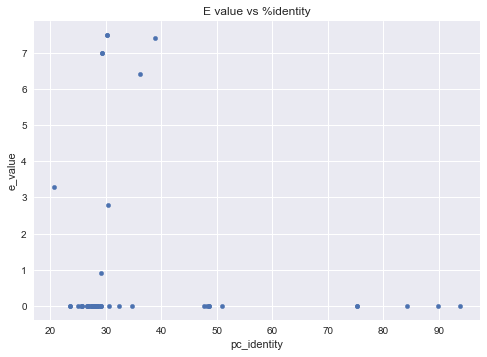

In [14]:
# Create a scatterplot
results.plot.scatter('pc_identity', 'e_value')
plt.title("E value vs %identity");              # add a title to the plot

<img src="images/exercise.png" style="width: 100px; float: left;">
<a id="ex01"></a>
### Exercise 01 (10min)

There is a second `BLASTX` query file in the directory `data/kitasatospora`, called `lantibiotic.fasta`. It describes the CDS for a suspected lantibiotic synthesis protein. To begin the analysis with this sequence, can you do the following?

<br><div class="alert-danger">
<ul>
<li> Create a `BLASTX` command-line to query the lantibiotic synthesis CDS against the <i>Kitasatospora</i> protein database, and write the output to a new file called `lantibiotic_blastx_kitasatospora.tab` in the output directory `output/kitasatospora`.
<li> Run the `BLASTX` search, capturing the `STDERR` and `STDOUT` streams
<li> Load the `BLASTX` results into a new dataframe
<li> Create a plot of percentage identity against bit score
</div></br>

In [15]:
# SOLUTION - EXERCISE 01
# !! Do not execute this cell if skipping computational step !!

# We can reuse the directories and db, but need to generate new filenames
query = os.path.join(datadir, 'lantibiotic.fasta')                                   # query sequence(s)
blastout = os.path.join(outdir, 'lantibiotic_blastx_kitasatospora.tab')              # BLAST output

# Create command-line for BLASTX
cmd_blastx = NcbiblastxCommandline(query=query, out=blastout, outfmt=6, db=db)

# Run BLASTX, and catch STDOUT/STDERR
stdout, stderr = cmd_blastx()

# Check STDOUT, STDERR
print("STDOUT: %s" % stdout)
print("STDERR: %s" % stderr)

STDOUT: 
STDERR: 


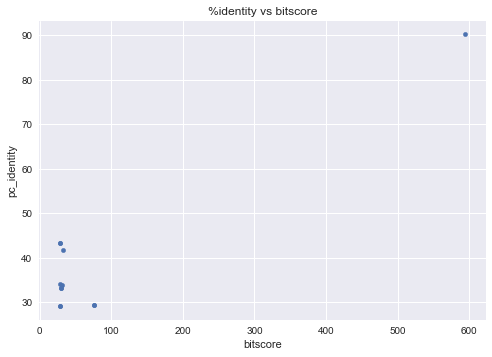

In [16]:
# !! Uncomment the line below, if skipping computational step !!
# blastout = os.path.join('prepped', 'kitasatospora', 'lantibiotic_blastx_kitasatospora.tab')

# Read BLASTX output, and reuse the column headers defined earlier
results = pd.read_csv(blastout, sep="\t", header=None)
results.columns = headers

# Create a scatterplot
results.plot.scatter('bitscore', 'pc_identity')
plt.title("%identity vs bitscore");                                                  # add a title to the plot